<h1>QUORA: IDENTIFYING QUESTION PAIRS WITH THE SAME INTENT

<h3>1. Installing & Importing necessary libraries</h3>

In [ ]:
!pip install wordcloud


In [ ]:
!pip install keras

In [ ]:
!pip install tensorflow


In [1]:
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from wordcloud import WordCloud # Importing wordcloud library for checking the most frequently occuring words
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
#import dataset
# Open the zip file and read the CSV
with zipfile.ZipFile('dataset.zip', 'r') as z:
with z.open('questions.csv') as f:
data = pd.read_csv(f)


In [3]:
#Display the entire scentences in columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

<h3>2.Exploratory Data Analysis:</h3>

In [7]:
df.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?,"I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone and video games?,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Motorolla DCX3400?,How do I hack Motorola DCX3400 for free internet?,0


In [8]:
# Information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404351 entries, 0 to 404350
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404351 non-null  int64 
 1   qid1          404351 non-null  int64 
 2   qid2          404351 non-null  int64 
 3   question1     404350 non-null  object
 4   question2     404349 non-null  object
 5   is_duplicate  404351 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [9]:
#null values check
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [10]:
#Drop the rows having null values
data = df.dropna()

<h3>3. Data Visualization:</h3>

3.1. Distribution of questions in the dataset

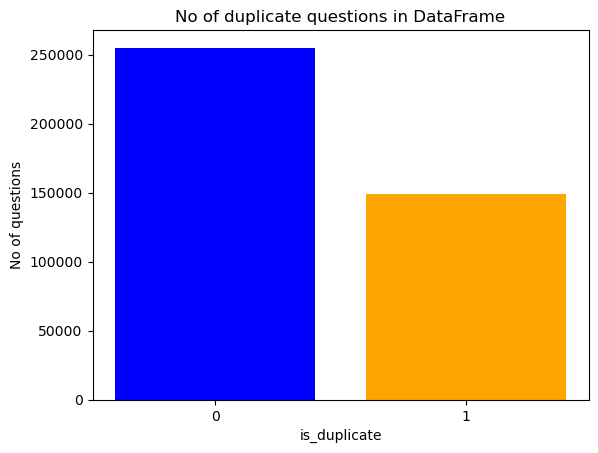

In [143]:
# Count the frequency of 'is_duplicate' values
is_duplicate_counts = df['is_duplicate'].value_counts()
plt.bar(is_duplicate_counts.index, is_duplicate_counts.values, color=['blue', 'orange'])
plt.xlabel('is_duplicate')
plt.ylabel('No of questions')
plt.title('No of duplicate questions in DataFrame')
plt.xticks([0, 1], ['0', '1'])
plt.show()


3.2. Percentage of duplicate questions in Dataset

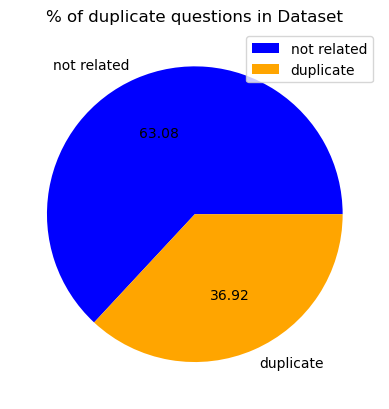

In [145]:
# frequency count of 'is_duplicate' values
is_duplicate_counts = df['is_duplicate'].value_counts()
colors = ['blue', 'orange']  # Blue for non-duplicate, orange for duplicate
plt.pie(is_duplicate_counts, autopct="%.2f", labels=['not related', 'duplicate'], colors=colors)
plt.title('% of duplicate questions in Dataset')
plt.legend()
plt.show()


3.3. WordCloud - Checking the most frequently occuring words in question1 and question2

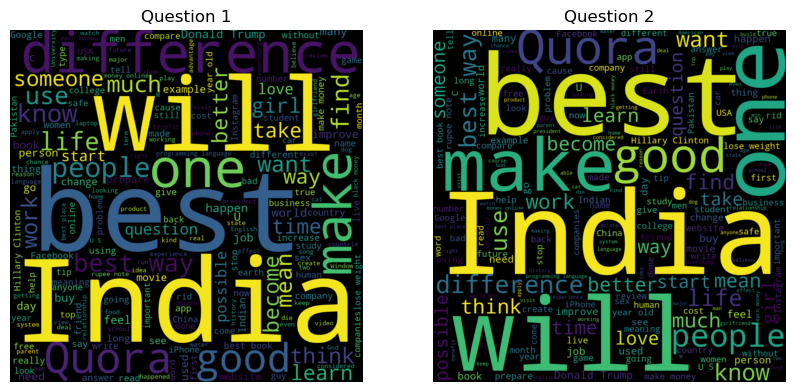

In [147]:
word_cloud_1 = WordCloud(width=1500, height=1500).generate(" ".join(df['question1'].astype(str)))
word_cloud_2 = WordCloud(width=1500, height=1500).generate(" ".join(df['question2'].astype(str)))

# Creating subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

# Plotting first word cloud
axes[0].imshow(word_cloud_1, interpolation='bilinear')
axes[0].set_title('Question 1')
axes[0].axis('off')

# Plotting second word cloud
axes[1].imshow(word_cloud_2, interpolation='bilinear')
axes[1].set_title('Question 2')
axes[1].axis('off')

# Saving the figure
plt.savefig("wordclouds.jpg")

# Displaying the plot
plt.show()


<h3>4. Data Wrangling</h3>

4.1. Removing unwanted columns

In [15]:
drop_column = ["qid1", "qid2", "id"]
data = data.drop(columns = drop_column)

4.2. Feature Engineering:

In [17]:
def word_share(x):
    word_1 = set(map(lambda word: word.lower().strip(), str(x['question1']).split(" ")))
    word_2 = set(map(lambda word: word.lower().strip(), str(x['question2']).split(" ")))
    return 1.0 * len(word_1 & word_2)/(len(word_1) + len(word_2))

In [18]:
def tfidf_word_share(x):
    count_vectorizer = CountVectorizer()
    document = []
    document.append(str(x[0]))
    document.append(str(x[1]))
    freq_term_matrix = count_vectorizer.fit_transform(document)
    tfidf = TfidfTransformer()
    tfidf.fit(freq_term_matrix)
    tf_idf_matrix = tfidf.fit_transform(freq_term_matrix)
    return (tf_idf_matrix * tf_idf_matrix.T).A[0, 1]

In [19]:
#Creating new dataframe 
new_data = pd.DataFrame(dtype='float64')
new_data['q1_length'] = data['question1'].str.len()   # Length of the question 1
new_data['q2_length'] = data['question2'].str.len()   # Length of the question 2
new_data['q1_words_num'] = data['question1'].apply(lambda x: len(str(x).split(" "))) # Number of words in question 1
new_data['q2_words_num'] = data['question2'].apply(lambda y: len(str(y).split(" "))) # Number of words in question 2
new_data['word_share'] = data.apply(word_share, axis=1) # Calculating word share between the two questions
new_data['TFIDF_share'] = data.apply(tfidf_word_share, axis=1, raw=True)

In [20]:
#Storing the Target column sperately
label = data['is_duplicate']

In [25]:
new_data.head()

,q1_length,q2_length,q1_words_num,q2_words_num,word_share,TFIDF_share
0,66,57,14,12,0.434783,0.920307
1,51,88,8,13,0.200000,0.424251
2,73,59,14,10,0.166667,0.225765
3,50,65,11,9,0.000000,0.000000
4,76,39,13,7,0.100000,0.272060


In [26]:
from sklearn.preprocessing import MinMaxScaler
# Initialize MinMaxScaler
scaler = MinMaxScaler()
# Fit and transform the scaler on the new_data
new_data_temp = scaler.fit_transform(new_data)
# Convert the scaled data into a DataFrame
new_data_scaled = pd.DataFrame(new_data_temp, columns=new_data.columns)

In [27]:
new_data_scaled.head()

,q1_length,q2_length,q1_words_num,q2_words_num,word_share,TFIDF_share
0,0.104502,0.047945,0.104839,0.046610,0.869565,0.920307
1,0.080386,0.074486,0.056452,0.050847,0.400000,0.424251
2,0.115756,0.049658,0.104839,0.038136,0.333333,0.225765
3,0.078778,0.054795,0.080645,0.033898,0.000000,0.000000
4,0.120579,0.032534,0.096774,0.025424,0.200000,0.272060


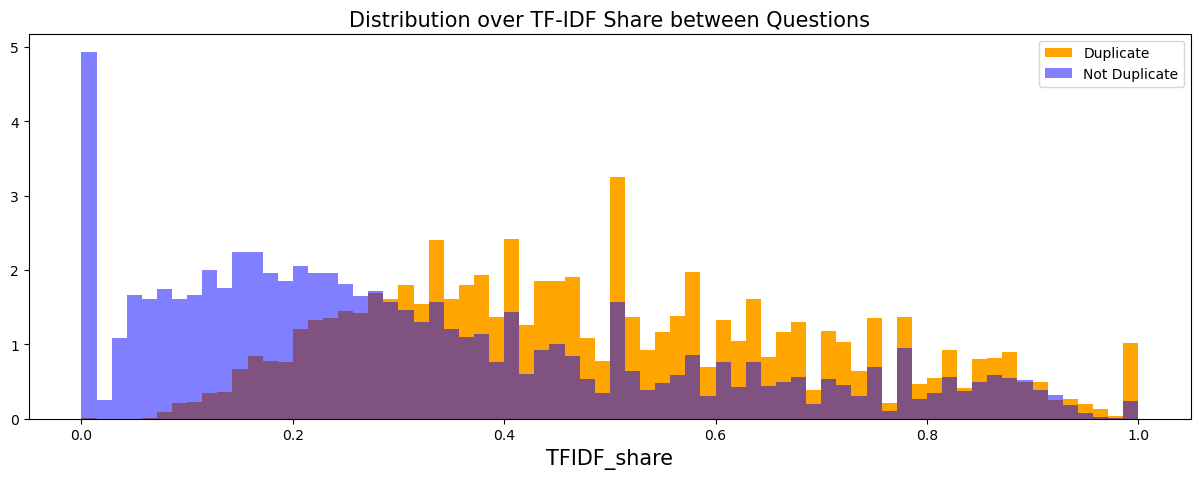

In [28]:
#Distribution over TF-IDF Share between Questions
plt.figure(figsize=(15, 5))
plot_tfidf_share = new_data['TFIDF_share']
plt.hist(plot_tfidf_share[df['is_duplicate'] == 1], bins=70, density=True, label='Duplicate', color='orange')
plt.hist(plot_tfidf_share[df['is_duplicate'] == 0], bins=70, alpha=0.5,density=True, label='Not Duplicate', color='blue')
plt.legend()
plt.title('Distribution over TF-IDF Share between Questions', fontsize=15)
plt.xlabel('TFIDF_share', fontsize=15)
plt.show()


<h3>5. Model Training</h3>

5.1. Train Test Split

In [33]:
#Splitting the dataset into training and testing sets
from sklearn.model_selection import train_test_split

# Assuming X is your feature matrix and y is your target variable
X_train, X_test, y_train, y_test = train_test_split(new_data_scaled, label, test_size=0.2, stratify=label, random_state=42)


In [34]:
# Evaluation of Performance of Model(After Hypertuning) 
def best_model_performance(model, y_test, y_test_pred_model):
    conf_matrix = confusion_matrix(y_test, y_test_pred_model)
    model_name = type(model).__name__
    print("Confusion Matrix for:" + " " + model_name)
    print(conf_matrix)

    # Calculate testing accuracy
    test_accuracy_model = accuracy_score(y_test, y_test_pred_model)
    

    # Calculate accuracy
    accuracy_model = accuracy_score(y_test, y_test_pred_model)

    # Calculate precision
    precision_model = precision_score(y_test, y_test_pred_model)

    # Calculate recall
    recall_model = recall_score(y_test, y_test_pred_model)

    # Calculate specificity
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity_model = tn / (tn + fp)

    # Calculate F1 score
    f1_model = f1_score(y_test, y_test_pred_model)
    print("Precision:", precision_model)
    print("Recall:", recall_model)
    print("Specificity:", specificity_model)
    print("F1 Score:", f1_model)
    print(" ")

In [35]:
# Predict probabilities for new data
def pred_prob(model, new_test_data):
    model_name = type(model).__name__
    new_data_probabilities = model.predict_proba(new_test_data)[:, 1]  # Probability of class 1
    print("Prediction for:" + " " + model_name, new_data_probabilities)
    # Print "duplicate" for probabilities greater than 0.5, and "non-duplicate" otherwise
    for i, probability in enumerate(new_data_probabilities):
        if probability > 0.5:
           print("Duplicate\n")
        else:
           print("Non-duplicate\n")

5.2. Logistic Regression

In [39]:
# Values of max_iter to be tested
max_iters = [5, 10, 20, 50, 70, 100,150]

# Lists to store train and test accuracies
train_accuracies = []
test_accuracies = []

# List to store F1 scores
f1_scores_lr = []

# Iterating over each value of max_iter
for max_iter in max_iters: 
    # logistic regression model with the current max_iter value
    lr_classifier = LogisticRegression(max_iter=max_iter, random_state=29)
    lr_classifier.fit(X_train, y_train)

    # Predict labels for training and testing data
    y_train_pred = lr_classifier.predict(X_train)
    y_test_pred = lr_classifier.predict(X_test)

    # Calculate accuracy for training and testing data
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Append accuracies to respective lists
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    # Calculate F1 score for testing data
    f1 = f1_score(y_test, y_test_pred)

    # Append F1 score to the list
    f1_scores_lr.append(f1)

    # Print the accuracies for each max_iter
    print(f"max_iter={max_iter}, Training Accuracy: {train_accuracy}, Testing Accuracy: {test_accuracy}, F1 Score for testing data: {f1}")

#f1_scores lists to numpy arrays
max_iters_lr = np.array(max_iters)
f1_scores_lr = np.array(f1_scores_lr)

# Find the index of the maximum F1 score
best_index = np.argmax(f1_scores_lr)

# Print the max_iter value corresponding to the best F1 score
print(f"Best max_iter: {max_iters_lr[best_index]}, Best F1 Score: {f1_scores_lr[best_index]}")

C:\Users\akhil\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


max_iter=5, Training Accuracy: 0.6514693425828032, Testing Accuracy: 0.65139112155311, F1 Score for testing data: 0.44508306432564365


C:\Users\akhil\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


max_iter=10, Training Accuracy: 0.6612474418662165, Testing Accuracy: 0.6606281686657599, F1 Score for testing data: 0.49418529644851544


C:\Users\akhil\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


max_iter=20, Training Accuracy: 0.6619028187388323, Testing Accuracy: 0.6623346111042414, F1 Score for testing data: 0.4968955542863459


C:\Users\akhil\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


max_iter=50, Training Accuracy: 0.6622985179826758, Testing Accuracy: 0.6620749350809942, F1 Score for testing data: 0.49709238130290756
max_iter=70, Training Accuracy: 0.6622676039792506, Testing Accuracy: 0.6621738592803265, F1 Score for testing data: 0.49703597334217015
max_iter=100, Training Accuracy: 0.6622676039792506, Testing Accuracy: 0.6621738592803265, F1 Score for testing data: 0.49703597334217015
max_iter=150, Training Accuracy: 0.6622676039792506, Testing Accuracy: 0.6621738592803265, F1 Score for testing data: 0.49703597334217015
Best max_iter: 50, Best F1 Score: 0.49709238130290756


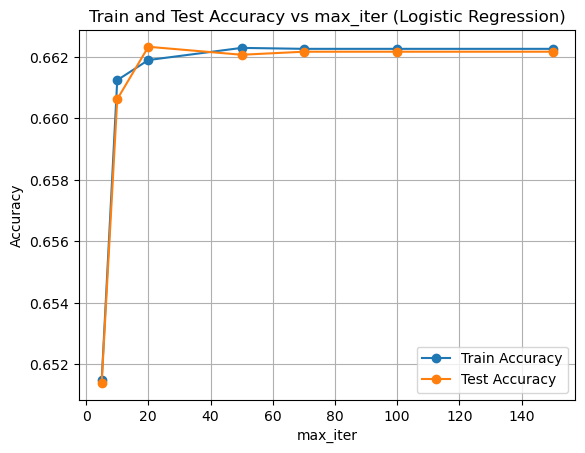

In [40]:
# Plotting train and test accuracies for Logistic Regression
plt.plot(max_iters, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(max_iters, test_accuracies, label='Test Accuracy', marker='o')
plt.title('Train and Test Accuracy vs max_iter (Logistic Regression)')
plt.xlabel('max_iter')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [135]:
# Model 1: Logistic Regression model after Hypertuning
best_lr_classifier = LogisticRegression(max_iter = 50)
best_lr_classifier.fit (X_train,y_train)

# Predict labels for training and testing data
y_train_pred_best_lr = best_lr_classifier.predict(X_train)
y_test_pred_best_lr = best_lr_classifier.predict(X_test)

# Calculate accuracy for training and testing data
train_accuracy_best_lr = accuracy_score(y_train, y_train_pred_best_lr)
test_accuracy_best_lr = accuracy_score(y_test, y_test_pred_best_lr)

# Print the accuracies
print("Training Accuracy:", train_accuracy_best_lr)
print("Testing Accuracy:", test_accuracy_best_lr)

#Confusion matrix
conf_matrix_lr = best_model_performance(best_lr_classifier, y_test, y_test_pred_best_lr)

Training Accuracy: 0.6622985179826758
Testing Accuracy: 0.6620749350809942
Confusion Matrix for: LogisticRegression
[[40036 10973]
 [16355 13506]]
Precision: 0.5517382246006781
Recall: 0.4522956364488798
Specificity: 0.7848810994138289
F1 Score: 0.49709238130290756
 


C:\Users\akhil\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


5.3. SVM

In [49]:
# Different values for max_iter
max_iters = [5,10,15,20,50,100,150,250,300,500]

# Lists to store train and test accuracies
train_accuracies_svm = []
test_accuracies_svm = []

# List to store F1 scores
f1_scores_svm = []

for max_iter in max_iters:
    # Initialize SVM classifier with the current max_iter value
    svm_classifier = SVC(max_iter=max_iter, random_state=29)
    svm_classifier.fit(X_train, y_train)

    # Predict labels for training and testing data
    y_train_pred_svm = svm_classifier.predict(X_train)
    y_test_pred_svm = svm_classifier.predict(X_test)

    # Calculate accuracy for training and testing data
    train_acc_svm = accuracy_score(y_train, y_train_pred_svm)
    test_acc_svm = accuracy_score(y_test, y_test_pred_svm)

    # Append accuracies to respective lists
    train_accuracies_svm.append(train_acc_svm)
    test_accuracies_svm.append(test_acc_svm)

    # Calculate F1 score for testing data
    f1 = f1_score(y_test, y_test_pred_svm)

    # Append F1 score to the list
    f1_scores_svm.append(f1)

    # Print the accuracies for each max_iter
    print(f"max_iter={max_iter}, Training Accuracy: {train_acc_svm}, Testing Accuracy: {test_acc_svm}, F1 Score for testing data: {f1}")

#f1_scores lists to numpy arrays
max_iters_svm = np.array(max_iters)
f1_scores_svm = np.array(f1_scores_svm)

# Find the index of the maximum F1 score
best_index = np.argmax(f1_scores_svm)

# Print the max_iter value corresponding to the best F1 score
print(f"Best max_iter: {max_iters_svm[best_index]}, Best F1 Score: {f1_scores_svm[best_index]}")

C:\Users\akhil\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


max_iter=5, Training Accuracy: 0.6711213745602483, Testing Accuracy: 0.6737850871769506, F1 Score for testing data: 0.6156558224915863


C:\Users\akhil\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


max_iter=10, Training Accuracy: 0.662434539597747, Testing Accuracy: 0.6647953505626314, F1 Score for testing data: 0.5395277730592832


C:\Users\akhil\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


max_iter=15, Training Accuracy: 0.6532314407780436, Testing Accuracy: 0.6553480895264004, F1 Score for testing data: 0.47922272047832587


C:\Users\akhil\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


max_iter=20, Training Accuracy: 0.6536240486215446, Testing Accuracy: 0.6554841103004823, F1 Score for testing data: 0.48291605575249164


C:\Users\akhil\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


max_iter=50, Training Accuracy: 0.6523720314828211, Testing Accuracy: 0.6541857301842463, F1 Score for testing data: 0.4763705811863391


C:\Users\akhil\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


max_iter=100, Training Accuracy: 0.6520412516461707, Testing Accuracy: 0.6538394954865834, F1 Score for testing data: 0.4730838729107062


C:\Users\akhil\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


max_iter=150, Training Accuracy: 0.6563104755192007, Testing Accuracy: 0.6584394707555336, F1 Score for testing data: 0.49796437659033077


C:\Users\akhil\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


max_iter=250, Training Accuracy: 0.6435058953004532, Testing Accuracy: 0.6435266477061952, F1 Score for testing data: 0.39801202806548613


C:\Users\akhil\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


max_iter=300, Training Accuracy: 0.6434533414946302, Testing Accuracy: 0.6432669716829479, F1 Score for testing data: 0.38352885868752273


C:\Users\akhil\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


max_iter=500, Training Accuracy: 0.6380032026907548, Testing Accuracy: 0.638370223816001, F1 Score for testing data: 0.3480102552669713
Best max_iter: 5, Best F1 Score: 0.6156558224915863


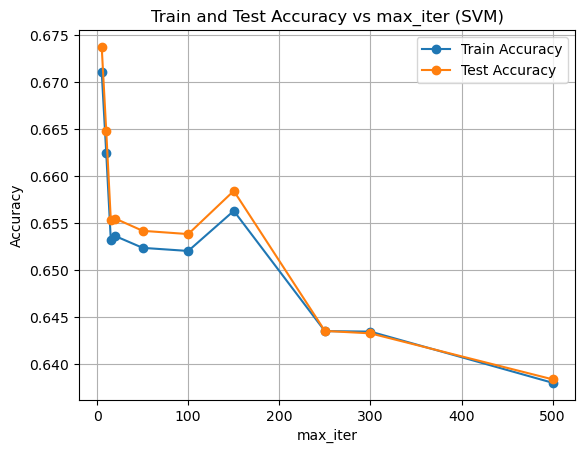

In [51]:
# Plotting train and test accuracies for SVM
plt.plot(max_iters, train_accuracies_svm, label='Train Accuracy',marker='o')
plt.plot(max_iters, test_accuracies_svm, label='Test Accuracy',marker='o')
plt.title('Train and Test Accuracy vs max_iter (SVM)')
plt.xlabel('max_iter')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('D:\iit madras\CAPSTONE PROJECT/accuracy_plot_SVM.png')
plt.show()

In [53]:
best_svm_model = SVC(probability=True, verbose=True, max_iter=5, random_state=29)
best_svm_model.fit(X_train, y_train)
print("\nHyperparameter used for SVM",best_svm_model)
#Confusion matrix
y_train_pred_best_svm = best_svm_model.predict(X_train)
y_test_pred_best_svm = best_svm_model.predict(X_test)

# Calculate accuracy for training and testing data
train_accuracy_best_svm = accuracy_score(y_train, y_train_pred_best_svm)
test_accuracy_best_svm = accuracy_score(y_test, y_test_pred_best_svm)
print("Train Accuracy",train_accuracy_best_svm)
print("Test Accuracy",test_accuracy_best_svm)

#Confusion Matrix
conf_matrix_svm = best_model_performance(best_svm_model, y_test,y_test_pred_best_svm)

[LibSVM]

C:\Users\akhil\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(



Hyperparameter used for SVM SVC(max_iter=5, probability=True, random_state=29, verbose=True)
Train Accuracy 0.6711213745602483
Test Accuracy 0.6737850871769506
Confusion Matrix for: SVC
[[33360 17649]
 [ 8732 21129]]
Precision: 0.5448708030326473
Recall: 0.707578446803523
Specificity: 0.6540022348997235
F1 Score: 0.6156558224915863
 


#### 5.4. Random Forest

In [57]:
# Different values for max_iter
max_depths = [5,10,15,20,30,50,100,150]

# Lists to store train and test accuracies
train_accuracies_rf = []
test_accuracies_rf = []

# List to store F1 scores
f1_scores_rf = []

for max_depth in max_depths:
    # Initialize SVM classifier with the current max_iter value
    rf_classifier = RandomForestClassifier(max_depth=max_depth, random_state=29)
    rf_classifier.fit(X_train, y_train)

    # Predict labels for training and testing data
    y_train_pred_rf = rf_classifier.predict(X_train)
    y_test_pred_rf = rf_classifier.predict(X_test)

    # Calculate accuracy for training and testing data
    train_acc_rf = accuracy_score(y_train, y_train_pred_rf)
    test_acc_rf = accuracy_score(y_test, y_test_pred_rf)

    # Append accuracies to respective lists
    train_accuracies_rf.append(train_acc_rf)
    test_accuracies_rf.append(test_acc_rf)

    # Calculate F1 score for testing data
    f1 = f1_score(y_test, y_test_pred_rf)

    # Append F1 score to the list
    f1_scores_rf.append(f1)

    # Print the accuracies for each max_iter
    print(f"max_depth={max_depth}, Training Accuracy: {train_acc_rf}, Testing Accuracy: {test_acc_rf}, F1 Score for testing data: {f1}")

#f1_scores lists to numpy arrays
max_depth_rf= np.array(max_depths)
f1_scores_rf = np.array(f1_scores_rf)

# Find the index of the maximum F1 score
best_index = np.argmax(f1_scores_rf)

# Print the max_iter value corresponding to the best F1 score
print(f"Best max_iter: {max_depth_rf[best_index]}, Best F1 Score: {f1_scores_rf[best_index]}")


max_depth=5, Training Accuracy: 0.7032595725211607, Testing Accuracy: 0.7023370842092247, F1 Score for testing data: 0.6350626118067979
max_depth=10, Training Accuracy: 0.71940595651018, Testing Accuracy: 0.7144923952021763, F1 Score for testing data: 0.6524572890795515
max_depth=15, Training Accuracy: 0.7623238674654845, Testing Accuracy: 0.7241375046370718, F1 Score for testing data: 0.6631434309269634
max_depth=20, Training Accuracy: 0.8456247410952213, Testing Accuracy: 0.7252751329293928, F1 Score for testing data: 0.6618880214278104
max_depth=30, Training Accuracy: 0.9540185113052511, Testing Accuracy: 0.7184493631754668, F1 Score for testing data: 0.6340977389236184
max_depth=50, Training Accuracy: 0.967945269848336, Testing Accuracy: 0.7122171386175343, F1 Score for testing data: 0.6096247714578057
max_depth=100, Training Accuracy: 0.9679483612486784, Testing Accuracy: 0.7114999381723754, F1 Score for testing data: 0.608651894593824
max_depth=150, Training Accuracy: 0.967948361

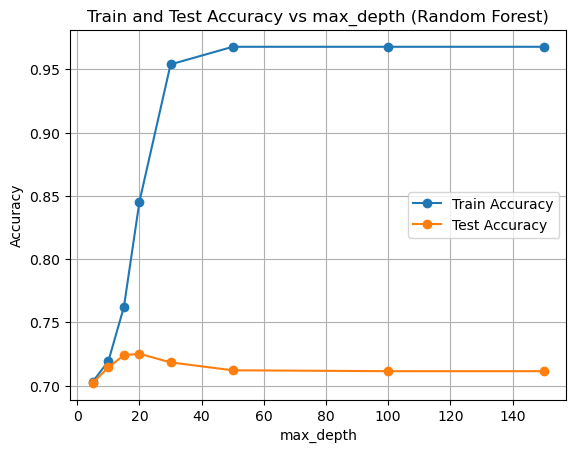

In [61]:
# Plotting train and test accuracies
plt.plot(max_depths, train_accuracies_rf, label='Train Accuracy', marker='o')
plt.plot(max_depths, test_accuracies_rf, label='Test Accuracy',marker='o')
plt.title('Train and Test Accuracy vs max_depth (Random Forest)')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('D:\iit madras\CAPSTONE PROJECT/accuracy_plot_RF.png')
plt.show()

In [63]:
best_rf_model = RandomForestClassifier(max_depth=15, random_state=29)
best_rf_model.fit(X_train, y_train)
print("\nHyperparameter used for Random Forest",best_rf_model)

y_train_pred_best_rf = best_rf_model.predict(X_train)
y_test_pred_best_rf = best_rf_model.predict(X_test)

# Calculate accuracy for training and testing data
train_accuracy_best_rf = accuracy_score(y_train, y_train_pred_best_rf)
test_accuracy_best_rf = accuracy_score(y_test, y_test_pred_best_rf)
print("Train Accuracy",train_accuracy_best_rf)
print("Test Accuracy",test_accuracy_best_rf)

#Confusion Matrix
conf_matrix_rf = best_model_performance(best_rf_model, y_test,y_test_pred_best_rf)


Hyperparameter used for Random Forest RandomForestClassifier(max_depth=15, random_state=29)
Train Accuracy 0.7623238674654845
Test Accuracy 0.7241375046370718
Confusion Matrix for: RandomForestClassifier
[[36602 14407]
 [ 7902 21959]]
Precision: 0.6038332508386954
Recall: 0.735373899065671
Specificity: 0.7175596463369209
F1 Score: 0.6631434309269634
 


<h3>6. Prediction Performance of Models</h3>

6.1. Prediction on Existing Data:

In [97]:
#Sample data selection
question1_test = data.loc[162, 'question1']
question2_test = data.loc[162, 'question2']
y_true = data.loc[162, 'is_duplicate']

# Print prediction question pairs
print("Prediction question pairs:")
print(question1_test)
print(question2_test)
print("y_true:",y_true)

# Create DataFrame for new test data
new_test = pd.DataFrame(dtype='float64')
new_test['question1'] = [question1_test]
new_test['question2'] = [question2_test]

# Feature engineering
new_test['q1_length'] = new_test['question1'].str.len()   # Length of question 1
new_test['q2_length'] = new_test['question2'].str.len()   # Length of question 2
new_test['q1_words_num'] = new_test['question1'].apply(lambda x: len(str(x).split(" "))) # Number of words in question 1
new_test['q2_words_num'] = new_test['question2'].apply(lambda y: len(str(y).split(" "))) # Number of words in question 2
new_test['word_share'] = new_test.apply(word_share, axis=1) # Calculating word share between the two questions
new_test['TFIDF_share'] = new_test.apply(tfidf_word_share, axis=1, raw=True)

# Drop unnecessary columns
drop_columns = ["question1", "question2"]
new_test = new_test.drop(columns=drop_columns)

# Scale the new test data using the previously fitted scaler
new_test_scaled = scaler.transform(new_test)

# Convert the scaled data into a DataFrame
new_test_scaled = pd.DataFrame(new_test_scaled, columns=new_test.columns)


Prediction question pairs:
What are stereotypes about the United Kingdom?
What do Americans think about the United Kingdom?
y_true: 0


In [137]:
# Prediction Performance of Diffrent Models on Existing Data
print("Prediction question pairs:")
print("Question1: ",question1_test)
print("Question2: ",question2_test)
print("\n")

pred_prob(best_lr_classifier , new_test_scaled)
pred_prob(best_svm_model , new_test_scaled)
pred_prob(best_rf_model , new_test_scaled)

Prediction question pairs:
Question1:  Which apple Iphone should i buy in 2024?
Question2:  Apple Iphone 16 better or samsung s24?


Prediction for: LogisticRegression [0.30372758]
Non-duplicate

Prediction for: SVC [0.46126132]
Non-duplicate

Prediction for: RandomForestClassifier [0.46674298]
Non-duplicate



6.2. Prediction on New Data:

In [125]:
question1_test = "Which apple Iphone should i buy in 2024?"
question2_test = "Apple Iphone 16 better or samsung s24?"

# Create DataFrame for new test data
new_test = pd.DataFrame(dtype='float64')
new_test['question1'] = [question1_test]
new_test['question2'] = [question2_test]

# Feature engineering
new_test['q1_length'] = new_test['question1'].str.len()   # Length of question 1
new_test['q2_length'] = new_test['question2'].str.len()   # Length of question 2
new_test['q1_words_num'] = new_test['question1'].apply(lambda x: len(str(x).split(" "))) # Number of words in question 1
new_test['q2_words_num'] = new_test['question2'].apply(lambda y: len(str(y).split(" "))) # Number of words in question 2
new_test['word_share'] = new_test.apply(word_share, axis=1) # Calculating word share between the two questions
new_test['TFIDF_share'] = new_test.apply(tfidf_word_share, axis=1, raw=True)

# Drop unnecessary columns
drop_columns = ["question1", "question2"]
new_test = new_test.drop(columns=drop_columns)

# Scale the new test data using the previously fitted scaler
new_test_scaled = scaler.transform(new_test)

# Convert the scaled data into a DataFrame
new_test_scaled = pd.DataFrame(new_test_scaled, columns=new_test.columns)

In [141]:
# Prediction Performance of Diffrent Models on New Data
print("Prediction question pairs:")
print("Question1: ",question1_test)
print("Question2: ",question2_test)
print("\n")

pred_prob(lr_classifier , new_test_scaled)
pred_prob(best_svm_model , new_test_scaled)
pred_prob(best_rf_model , new_test_scaled)

Prediction question pairs:
Question1:  Which apple Iphone should i buy in 2024?
Question2:  Apple Iphone 16 better or samsung s24?


Prediction for: LogisticRegression [0.30411343]
Non-duplicate

Prediction for: SVC [0.46126132]
Non-duplicate

Prediction for: RandomForestClassifier [0.46674298]
Non-duplicate

